# University Project II - Big Data

Author : Ophiase

In [1]:
ENABLE_DOWNLOAD = False
ENABLE_UNZIP = False
ENABLE_COMPUTE_ZIP_TO_PARQUET = False

### Dependencies

In [2]:
import shutil
import os
import requests
import pandas as pd
import re
import pyspark.sql.functions as F
import zipfile
from functools import reduce
import math

In [50]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pyspark
import logging

logging.getLogger("pyspark").setLevel(logging.ERROR)
# os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 2g"

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import when, mean, stddev, skewness, kurtosis, expr, date_format, count
import pyspark.sql.functions as pf
from pyspark.sql.functions import col, desc, lit, udf, dayofweek, avg, year, month, unix_timestamp, hour
from pyspark.sql.types import DoubleType


import seaborn as sns
import altair as alt
import plotly
import plotly.express as px

import scipy
from scipy.stats import skew, kurtosis

import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [4]:
spark = SparkSession.builder \
    .appName("Big Data Project") \
    .config("spark.driver.memory", "3g") \
    .config("spark.sql.files.maxPartitionBytes", "2g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 11:22:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Download the DATA

In [5]:
# from 2014 to 2023

zip_files = []

def download_data():
    trip_urls = [
        (year, f"https://s3.amazonaws.com/tripdata/{year}-citibike-tripdata.zip")
        for year in range(2014, 2023 + 1)
    ]

    if not os.path.exists(os.path.join('data')) :
        os.makedirs('data')

    for year, url in trip_urls:
        basename = os.path.join('data', str(year) + "_" + 'citibike_tripdata')
        zip_filename = basename + ".zip"
        csv_filename = basename + ".csv"
        zip_files.append((year, zip_filename, csv_filename))

        if not ENABLE_DOWNLOAD : continue
        print(f'Check {basename} ...')

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress = 0

        if not os.path.exists(zip_filename) and not os.path.exists(csv_filename) :
            with open(zip_filename, 'wb') as f:
                for data in response.iter_content(block_size):
                    if data:
                        f.write(data)
                        progress += len(data)
                        print(f'\rDownloaded {progress}/{total_size} bytes', end='')

            print(f'\nDownload complete: {zip_filename}')

    print("Finished")

download_data()

Finished


In [6]:
def unzip_data():
    for (year, zip_filename, csv_filename) in zip_files:
        # if year < 2018: continue # WARNING : DISABLE THIS LINE

        if not zipfile.is_zipfile(zip_filename):
            print("Corrupted zip file.")
            break

        if os.path.exists("tmp"):
            shutil.rmtree("tmp")

        print("Unzip : ", zip_filename)
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall("tmp")
        print("Process ..")

        # find the folder in tmp
        items = os.listdir("tmp")
        for folder in items :
            if not os.path.isdir(os.path.join("tmp", folder)) or \
                folder.startswith("__") :
                continue
            
            # find all the folder in this folder
            sub_folders = os.listdir(os.path.join("tmp", folder))
            for sub_folder in sub_folders :
                if not os.path.isdir(os.path.join("tmp", folder, sub_folder)) or \
                    sub_folder.startswith(".") : 
                    continue
                
                sub_item = os.listdir(os.path.join("tmp", folder, sub_folder))
                for leaf in sub_item :
                    # move the csv inside to data
                    from_path = os.path.join("tmp", folder, sub_folder, leaf)
                    dest_path = os.path.join("data", leaf)
                    if os.path.exists(dest_path) : 
                        os.remove(dest_path)

                    shutil.move(from_path, "data")

    if os.path.exists("tmp"):
        shutil.rmtree("tmp")

if ENABLE_UNZIP :
    unzip_data()

To optimize disk usage, we could have unziped one file at a time and convert its content instantaneously to `.parquet`.

## Convert the Data

### Technical/Raw Analysis

In [7]:
csv_reader = spark.read.option("header", "true") \
            .option("inferSchema", "true").csv

In [8]:
def find_all_csv():
    all_csv = []
    for item in os.listdir("data"):
        if not item.endswith(".csv") :
            continue
        all_csv.append(item)
    return sorted(all_csv)

all_csv = find_all_csv()

if False: # check column_names.txt
    for item in all_csv:    
        df = csv_reader(os.path.join("data", item))
        print(f"item {item} : {df.columns}")

By looking at the previous code output *(cached in `column_names.txt`)*, \
we notice the following columns between 2014-01 $\to$ 2021-01 (included) :
- `['tripduration', 'starttime', 'stoptime', 'start station id', 'start station name', `\
`'start station latitude', 'start station longitude', 'end station id', 'end station name', `\
`'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender']`
    - The naming convention is not exactly the same between : `201610-citibike-tripdata_1.csv` $\to$ `201703-citibike-tripdata.csv_1.csv` : \
    `['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',` \
    `'Start Station Name', 'Start Station Latitude', 'Start Station Longitude',` \
    `'End Station ID', 'End Station Name', 'End Station Latitude',` \
    `'End Station Longitude', 'Bike ID', 'User Type', 'Birth Year', 'Gender']`

The columns change between 2021-02 $\to$ 2023-12 (included) :
- `['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', `\
`'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', `\
`'start_lng', 'end_lat', 'end_lng', 'member_casual']`

We decide the following matching (**O.** as before 2021-02, **N.** as after 2021-02):

- `O.'tripduration'` as function : `stoptime` - `startime`
    - Renamed as `trip_duration`

- `N.'started_at'` $\leftarrow$ `O.'starttime'`
- `N.'ended_at'` $\leftarrow$ `O.'stoptime'` 
- `N.'start_station_id'` $\leftarrow$ `O.'start station id'`
    - type : string
- `N.'start_station_name'` $\leftarrow$ `O.'start station name'`
- `N.'start_lat'` $\leftarrow$ `O.'start station latitude'`
- `N.'start_lng'` $\leftarrow$ `O.'start station longitude'`
- `N.'end_station_id'` $\leftarrow$ `O.'end station id'`
    - type : string
- `N.'end_station_name'` $\leftarrow$ `O.'end station name'`
- `N.'end_lat'` $\leftarrow$ `O.'end station latitude'`
- `N.'end_lng'` $\leftarrow$ `O.'end station longitude'`
`
- `N.'ride_id'` $\leftarrow$ `O.'bikeid'` (format is not the same)
    - Both type of ID can registered as string

- `N.'member_casual'` $\leftarrow$ `O.'usertype'` (format is not the same)
    - Mapping : `O.Subscriber`, `O.Customer` $\to$ `N.member`, `N.casual`

- `O.'birth year` : (None) for elements of N
    - Renamed as `birth_year`
- `O.'gender'` : (None) for elements of N
- `N.'rideable_type'` : (None) for elements of O

- We will also add a binary column `old_format` to indicate if the data comes from `O` or `N` as defined above.

In [9]:
col_mapping_1 = {
    'tripduration': 'trip_duration',
    'usertype': 'member_casual',
    'birth year': 'birth_year',

    'starttime': 'started_at',
    'stoptime': 'ended_at',
    'start station id': 'start_station_id',
    'start station name': 'start_station_name',
    'start station latitude': 'start_lat',
    'start station longitude': 'start_lng',
    'end station id': 'end_station_id',
    'end station name': 'end_station_name',
    'end station latitude': 'end_lat',
    'end station longitude': 'end_lng',
    'bikeid': 'ride_id',
}

col_mapping_2 = {
    'Trip Duration': 'tripduration',
    'Start Time': 'starttime',
    'Stop Time': 'stoptime',
    
    'Start Station ID': 'start station id',
    'Start Station Name': 'start station name',
    'Start Station Latitude': 'start station latitude',
    'Start Station Longitude': 'start station longitude',

    'End Station ID': 'end station id',
    'End Station Name' : 'end station name',
    'End Station Latitude' : 'end station latitude',
    'End Station Longitude' : 'end station longitude',
    
    'Bike ID' : 'bikeid',
    'User Type' : 'usertype',
    'Birth Year' : 'birth year',
    'Gender' : 'gender'
}


In [10]:
def check_unique_values(df, column):
    return df.select(column).dropDuplicates().rdd.map(lambda row: row[0]).collect()

In [11]:
def fast_check():
    df_o = spark.read.csv(os.path.join("data", all_csv[0]), header=True, inferSchema=True)
    df_o = df_o.select(
        [col(old_col).alias(col_mapping_1.get(old_col, old_col)) for old_col in df_o.columns]
        )

    df_n = spark.read.csv(os.path.join("data", all_csv[-1]), header=True, inferSchema=True)
    
    print(check_unique_values(df_o, "member_casual"))
    print(check_unique_values(df_o, "gender"))
    print(check_unique_values(df_n, "rideable_type"))

    df_o.printSchema()
    df_n.printSchema()
    
    # df.show()

fast_check()

['Subscriber', 'Customer']
[1, 2, 0]
['electric_bike', 'classic_bike']
root
 |-- trip_duration: integer (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- ride_id: integer (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- gender: integer (nullable = true)

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = 

### File format Selection : Parquet

<img src="resources/file-formats.png" alt="Drawing" style="width: 400px;"/>

Our [course](https://stephane-v-boucheron.fr/slides/tbd/slides06_file-formats.html#/title-slide) on Big Data file formats.

Parquet suits our needs for the project:

- Suitable for laptop execution
- 37GB dataset size manageable with Parquet's compression
- Supports splitability for processing subsets of data on minimal configuration
- Compatible with Apache Spark

### CSV $\to$ Parquet

In [12]:
if not os.path.exists(os.path.join('computed')) :
    os.makedirs('computed')

In [13]:
factorial_columns = ["member_casual", "gender", "rideable_type"]

In [58]:
# Lower Case O. part

# add missing columns
def csv_o_process(df):
    df = df.select(
        [col(old_col).alias(col_mapping_1.get(old_col, old_col)) for old_col in df.columns])

    df = df.withColumn("birth_year", 
                       when(col("birth_year") == r"\N", lit(None))
                       .otherwise(col("birth_year"))
                       .cast("integer")
                       )

    df = df.withColumn("start_station_id", col("start_station_id").cast("string"))\
            .withColumn("end_station_id", col("end_station_id").cast("string")) \
            .withColumn("ended_at", col("ended_at").cast("timestamp")) \
            .withColumn("started_at", col("started_at").cast("timestamp")) \
            .withColumn("ride_id", col("ride_id").cast("string"))

    df = df.withColumn("member_casual",
                        when(col("member_casual") == "Subscriber", lit("member")) \
                        .otherwise(lit("casual")))
    
    df = df.withColumn("rideable_type", lit(None).cast('string'))
    df = df.withColumn("old_format", lit(True))
    
    df = df.withColumn("gender", 
         when(col('gender') == 0, lit(None) ) \
        .when(col('gender') == 1, lit("Male")) \
        .when(col('gender') == 2, lit("Female")).cast("string"))

    df = df.select(*sorted(df.columns))

    # df.write.mode("append").parquet(parquet_file)
    return df

def csv_to_parquet_part_1(csv_file) :
    df = spark.read.csv(csv_file, header=True, inferSchema=True)
    return csv_o_process(df)

In [59]:
# Upper case O. part

def csv_to_parquet_part_2(csv_file) :
    df = spark.read.csv(csv_file, header=True, inferSchema=True)
    
    df = df.select(
        [col(old_col).alias(col_mapping_2.get(old_col, old_col)) for old_col in df.columns])
    
    return csv_o_process(df)

In [60]:
# N. Part

def csv_to_parquet_part_3(csv_file) :
    df = spark.read.csv(csv_file, header=True, inferSchema=True)

    # df = df.withColumn("trip_duration", 
    #     (unix_timestamp(col("ended_at")) - unix_timestamp(col("started_at"))) \
    #     .cast("integer"))
    
    df = df.withColumn("trip_duration", 
        F.when(
            (col("started_at").isNotNull()) & (col("ended_at").isNotNull()) & (col("ended_at") > col("started_at")),
            (F.unix_timestamp(col("ended_at")) - F.unix_timestamp(col("started_at"))).cast("integer")
        ).otherwise(None))
    
    df = df.withColumn("old_format", lit(False))
    df = df.withColumn("birth_year", lit(None).cast("integer"))

    df = df.withColumn("gender", lit(None).cast("string"))

    df = df.withColumn("start_station_id", col("start_station_id").cast("string"))\
            .withColumn("end_station_id", col("end_station_id").cast("string")) \
            .withColumn("ended_at", col("ended_at").cast("timestamp")) \
            .withColumn("started_at", col("started_at").cast("timestamp")) \
            .withColumn("ride_id", col("ride_id").cast("string"))

    df = df.select(*sorted(df.columns))

    # df.write.mode("append").parquet(parquet_file)
    return df


#### File Partitioning

We decide to partition columns on `"year(started_at)"`, `"month(started_at)"`, `"start_station_id"`

Even with Lazy Loading of the CSV file, dataset doesn't seems to fit in RAM, thus we partition by hand the .parquet file intos multiples files

In [ ]:
# Scheduler

schedule = [
    ("201401-citibike-tripdata_1.csv", 1),
    ("201610-citibike-tripdata_1.csv", 2),
    ("201704-citibike-tripdata.csv_1.csv", 1),
    ("202102-citibike-tripdata_1.csv", 3)
]

def process_csv_files(csv_files, schedule):
    schedule_pointer = 0
    df_buffer = []

    for index, csv_file in enumerate(csv_files):
        csv_path = os.path.join("data", csv_file)
        
        if index % 20 == 0 :
            print(f"[{schedule_pointer}, {index}] {csv_file}")
        if (schedule_pointer < len(schedule) - 1) and (csv_file == schedule[schedule_pointer + 1][0]) :
            schedule_pointer += 1
            print(f"{csv_file} | {schedule_pointer} : {schedule[schedule_pointer]}")

        schedule_mode = schedule[schedule_pointer][1]
        target_function = [csv_to_parquet_part_1, csv_to_parquet_part_2, csv_to_parquet_part_3][schedule_mode - 1]

        df_to_add = target_function(csv_path)
        df_buffer.append(df_to_add)

    print ("REDUCE STEP")
    
    df = reduce(lambda df1, df2: df1.union(df2), df_buffer)
    df = df.withColumn("year",
        when(col("started_at").isNotNull(), 
                year(col("started_at")).cast("integer")
            ).otherwise(lit(None).cast("integer"))
    )

    print ("WITH year/month")

    parquet_path = os.path.join(
        'computed', 'travels', f'travels.parquet')

    df \
        .partitionBy("year") \
        .mode("overwrite").parquet(parquet_path)
        # .write.option("maxRecordsPerFile", 70000000) \

if ENABLE_COMPUTE_ZIP_TO_PARQUET :
    process_csv_files(all_csv, schedule)

### Verifying Parquet is working

In [32]:
df = spark.read.parquet(os.path.join("computed", "travels", "*.parquet"))

print("Number of rows : " + str(df.count()))
df.show()

Number of rows : 200414362
+----------+-----------------+------------------+--------------+--------------------+-------------------+------+-------------+----------+----------------+-------------+-----------------+------------------+----------------+--------------------+-------------------+-------------+----+
|birth_year|          end_lat|           end_lng|end_station_id|    end_station_name|           ended_at|gender|member_casual|old_format|         ride_id|rideable_type|        start_lat|         start_lng|start_station_id|  start_station_name|         started_at|trip_duration|year|
+----------+-----------------+------------------+--------------+--------------------+-------------------+------+-------------+----------+----------------+-------------+-----------------+------------------+----------------+--------------------+-------------------+-------------+----+
|      NULL|        40.797911|          -73.9423|       7599.09|E 115 St & Lexing...|2023-12-30 13:24:13|  NULL|       membe

### Dimension tables

In [13]:
stations_dim = df.select("start_station_id", "start_station_name", 
                                "start_lat", "start_lng") \
                        .withColumnRenamed("start_station_id", "station_id") \
                        .withColumnRenamed("start_station_name", "station_name") \
                        .withColumnRenamed("start_lat", "lat") \
                        .withColumnRenamed("start_lng", "lng")

stations_dim = stations_dim.unionByName(
    df.select("end_station_id", "end_station_name", 
                    "end_lat", "end_lng") \
             .withColumnRenamed("end_station_id", "station_id") \
             .withColumnRenamed("end_station_name", "station_name") \
             .withColumnRenamed("end_lat", "lat") \
             .withColumnRenamed("end_lng", "lng")
            ).distinct()

                #, allowMissingColumns=True

stations_dim = stations_dim.groupBy("station_id").agg(
    F.first("station_name").alias("station_name"),
    F.first("lat").alias("lat"),
    F.first("lng").alias("lng")
)

stations_dim.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortAggregate(key=[station_id#506], functions=[first(station_name#511, false), first(lat#516, false), first(lng#521, false)])
   +- Sort [station_id#506 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(station_id#506, 200), ENSURE_REQUIREMENTS, [plan_id=367]
         +- SortAggregate(key=[station_id#506], functions=[partial_first(station_name#511, false), partial_first(lat#516, false), partial_first(lng#521, false)])
            +- Sort [station_id#506 ASC NULLS FIRST], false, 0
               +- Union
                  :- Project [start_station_id#272 AS station_id#506, start_station_name#273 AS station_name#511, start_lat#270 AS lat#516, start_lng#271 AS lng#521]
                  :  +- FileScan parquet [start_lat#270,start_lng#271,start_station_id#272,start_station_name#273,year#276] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/home/astragaliton/Documents/documentat

In [14]:
stations_dim.write \
            .mode("overwrite") \
            .parquet(os.path.join("computed", "stations_dim", "stations_dim.parquet"))

#.option("maxRecordsPerFile", 70000000) \

In [16]:
df_station_dim = spark.read.parquet(os.path.join("computed", "stations_dim", "stations_dim_bis.parquet"))
df_station_dim.show()
df_station_dim.countRaw()

+----------+--------------------+------------------+------------------+
|station_id|        station_name|               lat|               lng|
+----------+--------------------+------------------+------------------+
|       116|     W 17 St & 8 Ave|       40.74177603|      -74.00149746|
|       119|Park Ave & St Edw...|       40.69608941|      -73.97803415|
|     119.0|Park Ave & St Edw...|       40.69608941|      -73.97803415|
|       127|Barrow St & Hudso...|       40.73172428|      -74.00674436|
|       128|MacDougal St & Pr...|       40.72710258|      -74.00297088|
|     128.0|MacDougal St & Pr...|       40.72710258|      -74.00297088|
|       137|E 56 St & Madison...|         40.761628|        -73.972924|
|       143|Clinton St & Jora...|       40.69239502|      -73.99337909|
|     143.0|Clinton St & Jora...|       40.69239502|      -73.99337909|
|       144| Nassau St & Navy St|       40.69839895|      -73.98068914|
|     146.0|Hudson St & Reade St|       40.71625008|       -74.0

4833

Removing `end_station_name` and `start_station_name` columns from `travels.parquet` would optimize memory. However, removing latitude and longitude attributes would negatively impact performance when calculating travel distances due to the high cost of required joins.

## Analysis

### Split before/after Covid-19

In [33]:
end_date_pre_covid = '2020-02-29'
start_date_post_covid = '2020-03-01'

df_pre_covid = df.filter(col('ended_at') <= end_date_pre_covid)
df_2018 = df.filter((col('ended_at') <= '2019-01-01') & (col('started_at') > '2018-01-01')) 

df_post_covid = df.filter(col('started_at') >= start_date_post_covid)
df_2022 = df.filter((col('ended_at') <= '2023-01-01') & (col('started_at') > '2022-01-01')) 

In [34]:
print("Before Covid-19")
df_pre_covid.show(5)

Before Covid-19


+----------+-----------+------------+--------------+--------------------+--------------------+------+-------------+----------+-------+-------------+------------------+------------------+----------------+--------------------+--------------------+-------------+----+
|birth_year|    end_lat|     end_lng|end_station_id|    end_station_name|            ended_at|gender|member_casual|old_format|ride_id|rideable_type|         start_lat|         start_lng|start_station_id|  start_station_name|          started_at|trip_duration|year|
+----------+-----------+------------+--------------+--------------------+--------------------+------+-------------+----------+-------+-------------+------------------+------------------+----------------+--------------------+--------------------+-------------+----+
|      1993|40.71850211|-73.98329859|         349.0|Rivington St & Ri...|2018-12-20 14:12:...|  Male|       member|      true|  34649|         NULL|       40.72580614|      -73.97422494|           339.0|  

In [55]:
print("After Covid-19")
df_post_covid.show(5)

After Covid-19
+----------+-----------------+-----------------+--------------+--------------------+-------------------+------+-------------+----------+----------------+-------------+-----------------+------------------+----------------+--------------------+-------------------+-------------+
|birth_year|          end_lat|          end_lng|end_station_id|    end_station_name|           ended_at|gender|member_casual|old_format|         ride_id|rideable_type|        start_lat|         start_lng|start_station_id|  start_station_name|         started_at|trip_duration|
+----------+-----------------+-----------------+--------------+--------------------+-------------------+------+-------------+----------+----------------+-------------+-----------------+------------------+----------------+--------------------+-------------------+-------------+
|      NULL|40.72970805644994|-73.9865979552269|       5746.02|     E 10 St & 2 Ave|2023-09-03 10:24:16|  NULL|       member|     false|B0A0F1DEFA4B72FC|e

#### Compute distances and durations

In [35]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Rayon de la Terre en kilomètres
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

haversine_udf = udf(haversine, DoubleType())

In [36]:
def compte_trip_distance(df, verbose=False):
    if verbose : print("compute distance")

    df = df.filter(
        col("start_lat").isNotNull() & 
        col("start_lng").isNotNull() & 
        col("end_lat").isNotNull() & 
        col("end_lng").isNotNull()
    )

    df = df.withColumn(
        "distance_km", haversine_udf(col("start_lat"), 
                                     col("start_lng"), 
                                     col("end_lat"), 
                                     col("end_lng")))
    
    return df

df_2018 = compte_trip_distance(df_2018)
df_2022 = compte_trip_distance(df_2022)
df_post_covid = compte_trip_distance(df_post_covid)

### Trip distance by day

In [58]:
def compute_trip_distance_over_week(df, verbose=False):
    '''
        Returns in the pandas format
    '''
    if verbose : print("compute day of week")
    df = df.withColumn("day_of_the_week", dayofweek(col("started_at")))

    if verbose : print("group by")
    
    avg_distance_by_day_of_the_week = df.groupBy("day_of_the_week") \
        .agg(avg("distance_km").alias("avg_distance_km"))
    
    avg_distance_by_day_of_the_week = avg_distance_by_day_of_the_week.withColumn(
        "day_of_the_week",
        when(col("day_of_the_week") == 1, "Sunday")
        .when(col("day_of_the_week") == 2, "Monday")
        .when(col("day_of_the_week") == 3, "Tuesday")
        .when(col("day_of_the_week") == 4, "Wednesday")
        .when(col("day_of_the_week") == 5, "Thursday")
        .when(col("day_of_the_week") == 6, "Friday")
        .when(col("day_of_the_week") == 7, "Saturday")
    )

    return avg_distance_by_day_of_the_week.toPandas()

In [59]:
trip_distance_over_week_2018 = compute_trip_distance_over_week(df_2018)
trip_distance_over_week_2022 = compute_trip_distance_over_week(df_2022)

In [60]:
def visualize_trip_distance_over_week(df_1, df_2, description_1="", description_2=""):
    def specific_chart(df, description_bonus):
        min_value = df['avg_distance_km'].min() * 0.99
        max_value = df['avg_distance_km'].max() * 1.02

        return alt.Chart(df).mark_bar().encode(
                x=alt.X('day_of_the_week:O', title='Day', sort=None),
                y=alt.Y('avg_distance_km:Q', title='Average distance (km)',
                        scale=alt.Scale(domain=(min_value, max_value))),
                color=alt.Color('day_of_the_week:N', title='Day of The Week'),
                tooltip=['avg_distance_km', 'day_of_the_week']
            ).properties(
                title= 'Average trip distance per Day' + description_bonus,
                width= 300,
                height= 200
            )
        
    chart = alt.hconcat(
        specific_chart(df_1, description_1),
        specific_chart(df_2, description_2)
    ).configure_axis(
        labelAngle=45
    )

    chart = chart.configure_axis(
        titleFontSize=12,
        labelFontSize=10,
        labelOverlap='parity'
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=10
    )

    return chart

visualize_trip_distance_over_week(
    trip_distance_over_week_2018, trip_distance_over_week_2022, 
    "(2018)", "(2022)"
    ).interactive()

alt.HConcatChart(...)

###  Number of trips for each pickup/dropoff location couple

In [59]:
def aggregate_on_pickup_dropoff(df):
    return df.groupBy(
        "start_station_id", "end_station_id"
        ).agg(
            count("*").alias("count"),
            F.concat_ws(" -> ", 
                      F.first("start_station_name"), 
                      F.first("end_station_name")
                      ).alias("station_pair")
        )
    
def reduce_pickup_dropoff(df):
    return df.groupBy("count") \
        .agg(count("*").alias("frequency")) \
        .toPandas()

def top_10_pickup_dropoff(agg_df):
    top_10_df = agg_df.orderBy(desc("count")).limit(10)
    return top_10_df.toPandas()

def visualize_number_of_pickup_drop(df, date):
    df = reduce_pickup_dropoff(df)
    plt.figure(figsize=(10, 6))
    sns.histplot(df["count"], bins=30, kde=True)
    plt.xlabel("Number of couple (start_station_id, end_station_id) during " + date)
    plt.ylabel("Number of occurences the couple")
    plt.title("(start_station_id, end_station_id)")
    plt.show()

def visualize_top_10_pickup_dropoff(top_10_df, date):
    plt.figure(figsize=(12, 8))
    
    ax = sns.barplot(x="count", y="station_pair", data=top_10_df, dodge=False)
    plt.xlabel("Number of Occurrences")
    plt.ylabel("Station Pair")
    plt.title("Top 10 Most Frequent Start-End Station Pairs during " + date)
    
    # ax.legend().remove()
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    wrapped_labels = ["\n".join(label.split(" -> ")) for label in labels]
    ax.set_yticklabels(wrapped_labels)
    
    plt.show()

def full_visualization(df, date):
    agg = aggregate_on_pickup_dropoff(df)
    visualize_number_of_pickup_drop(agg, date)
    visualize_top_10_pickup_dropoff(top_10_pickup_dropoff(agg), date)


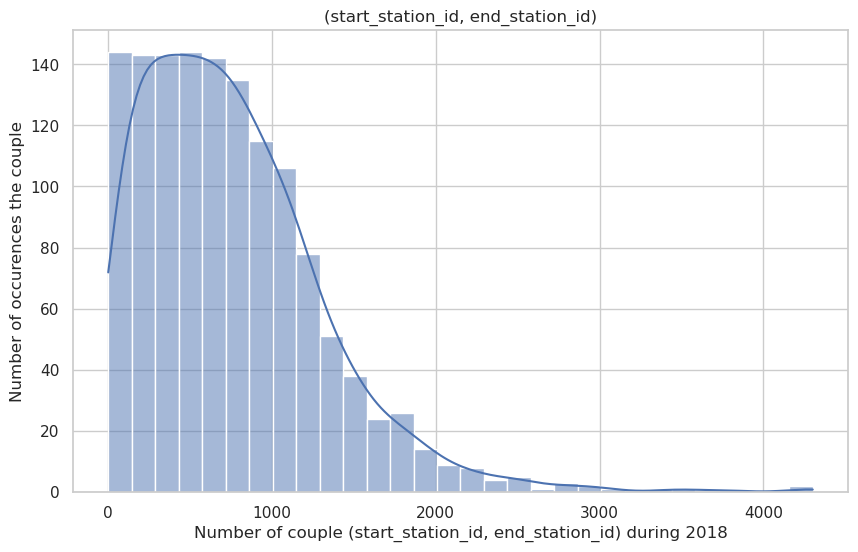

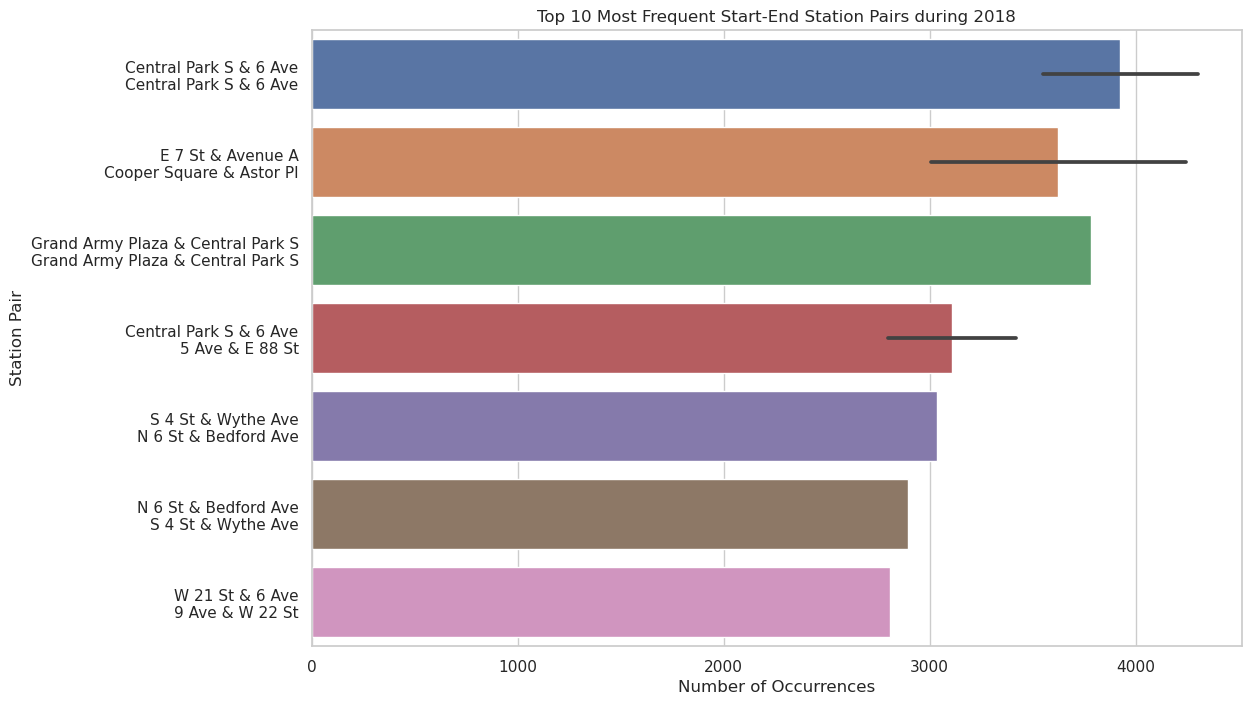

In [60]:
full_visualization(df_2018, "2018")

In [61]:
full_visualization(df_2022, "2022")

### Trip distance distribution for gender

In [61]:
def compute_trip_distance_over_genders(df, verbose=False):
    '''
        Returns in Pandas format
    '''
    df = df.filter(col("gender").isNotNull())
    
    avg_distance = df.groupBy("gender") \
        .agg(avg("distance_km").alias("avg_distance_km"))
    
    return avg_distance.toPandas()

In [67]:
trip_distance_over_genders_2018 = compute_trip_distance_over_genders(df_2018)
trip_distance_over_genders_post_covid = compute_trip_distance_over_genders(df_post_covid)

In [68]:
def visualize_trip_distance_over_genders(df_1, df_2, description_1="", description_2=""):
    def specific_chart(df, description_bonus):
        min_value = 0 # df['avg_distance_km'].min() * 0.99
        max_value = df['avg_distance_km'].max() * 1.02

        return alt.Chart(df).mark_bar().encode(
                x=alt.X('gender:O', title='Gender', sort=None),
                y=alt.Y('avg_distance_km:Q', title='Average distance (km)',
                        scale=alt.Scale(domain=(min_value, max_value))),
                color=alt.Color('gender', title='Gender'),
                tooltip=['avg_distance_km', 'gender']
            ).properties(
                title= 'Average trip distance per Gender' + description_bonus,
                width= 300,
                height= 200
            )
        
    chart = alt.hconcat(
        specific_chart(df_1, description_1),
        specific_chart(df_2, description_2)
    ).configure_axis(
        labelAngle=45
    )

    chart = chart.configure_axis(
        titleFontSize=12,
        labelFontSize=10,
        labelOverlap='parity'
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=10
    )

    return chart

visualize_trip_distance_over_genders(
    trip_distance_over_genders_2018, trip_distance_over_genders_post_covid,
    " (2018)", " (post covid)"
    ).interactive()


alt.HConcatChart(...)

### Trip distance distribution for age ranges

In [69]:
def compute_trip_distance_over_ages(df, verbose=False):
    '''
        Returns in Pandas format
    '''
        
    df = df.filter(col("birth_year").isNotNull())
    df = df.withColumn("age", year(col('started_at')) - col('birth_year'))

    df = df.withColumn(
        "age_range", 
         when(col('age') <= 14, lit(None) ) \
        .when((15 <= col('age')) & (col('age') <= 24), lit('15-24')) \
        .when((25 <= col('age')) & (col('age') <= 44), lit('25-45')) \
        .when((45 <= col('age')) & (col('age') <= 54), lit('45-54')) \
        .when((55 <= col('age')) & (col('age') <= 64), lit('55-64')) \
        .when(65 <= col('age'), lit('65+')) \
    )

    avg_distance = df.groupBy("age_range") \
        .agg(avg("distance_km").alias("avg_distance_km"))

    return avg_distance.toPandas()

In [70]:
trip_distance_over_ages_2018 = compute_trip_distance_over_ages(df_2018)
trip_distance_over_ages_post_covid = compute_trip_distance_over_ages(df_post_covid)

In [73]:
def visualize_trip_distance_over_ages(df_1, df_2, description_1="", description_2=""):
    def specific_chart(df, description_bonus):
        min_value = 0 # df['avg_distance_km'].min() * 0.80
        max_value = df['avg_distance_km'].max() * 1.02

        return alt.Chart(df).mark_bar().encode(
                x=alt.X('age_range:O', title='Age Range', sort=None),
                y=alt.Y('avg_distance_km:Q', title='Average distance (km)',
                        scale=alt.Scale(domain=(min_value, max_value))),
                color=alt.Color('age_range', title='Age Range'),
                tooltip=['avg_distance_km', 'age_range']
            ).properties(
                title= 'Average trip distance per age range' + description_bonus,
                width= 300,
                height= 200
            )
        
    chart = alt.hconcat(
        specific_chart(df_1, description_1),
        specific_chart(df_2, description_2)
    ).configure_axis(
        labelAngle=45
    )

    chart = chart.configure_axis(
        titleFontSize=12,
        labelFontSize=10,
        labelOverlap='parity'
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=10
    )

    return chart

visualize_trip_distance_over_ages(
    trip_distance_over_ages_2018, trip_distance_over_ages_post_covid,
    " (2018) ", " (post covid) "
    ).interactive()


alt.HConcatChart(...)

### Trip distance distribution for different kind of bikes

In [ ]:
def compute_trip_distance_over_bikes(df, verbose=False):
    df = df.filter(col("rideable_type").isNotNull())
    
    avg_distance = df.groupBy("rideable_type") \
        .agg(avg("distance_km").alias("avg_distance_km"))

    return avg_distance.toPandas

trip_distance_over_bikes_2022 = compute_trip_distance_over_bikes(df_2022)

In [ ]:
def visualize_trip_distance_over_bikes(df_1):
    min_value = 0 # df['avg_distance_km'].min() * 0.80
    max_value = df['avg_distance_km'].max() * 1.02

    chart = alt.Chart(df).mark_bar().encode(
            x=alt.X('rideable_type:O', title='Age Range', sort=None),
            y=alt.Y('avg_distance_km:Q', title='Average distance (km)',
                    scale=alt.Scale(domain=(min_value, max_value))),
            color=alt.Color('rideable_type', title='Type of bike'),
            tooltip=['avg_distance_km', 'age_range']
        ).properties(
            title= 'Average trip distance per type of types of bike after covid',
            width= 300,
            height= 200
        )
        
    chart = chart.configure_axis(
        labelAngle=45,
        titleFontSize=12,
        labelFontSize=10,
        labelOverlap='parity'
    ).configure_legend(
        titleFontSize=12,
        labelFontSize=10
    )

    return chart

visualize_trip_distance_over_bikes(
    trip_distance_over_bikes_post_covid,
    ).interactive()


### Hour of the week

In [ ]:
def compute_hour_of_the_week(df):
    df = df.dropna(subset=["started_at"])
    df = df.withColumn("day_of_the_week", dayofweek(col("started_at")) -1)
    df = df.withColumn("hour_of_the_day", hour(col("started_at")) - 1)
    df = df.withColumn("hour_of_the_week", 
                col("day_of_the_week")*24 + col("hour_of_the_day"))
    
    return df

### The number of pickups/docks

### The average distance

### The average trip duration

### The average number of ongoing trips

## Monitoring

In [17]:
df.explain(True)

== Parsed Logical Plan ==
Relation [birth_year#259,end_lat#260,end_lng#261,end_station_id#262,end_station_name#263,ended_at#264,gender#265,member_casual#266,old_format#267,ride_id#268,rideable_type#269,start_lat#270,start_lng#271,start_station_id#272,start_station_name#273,started_at#274,trip_duration#275,year#276] parquet

== Analyzed Logical Plan ==
birth_year: int, end_lat: double, end_lng: double, end_station_id: string, end_station_name: string, ended_at: timestamp, gender: string, member_casual: string, old_format: boolean, ride_id: string, rideable_type: string, start_lat: double, start_lng: double, start_station_id: string, start_station_name: string, started_at: timestamp, trip_duration: int, year: int
Relation [birth_year#259,end_lat#260,end_lng#261,end_station_id#262,end_station_name#263,ended_at#264,gender#265,member_casual#266,old_format#267,ride_id#268,rideable_type#269,start_lat#270,start_lng#271,start_station_id#272,start_station_name#273,started_at#274,trip_duration#27

2] Relation doesn't differ between Analyzed and Optimized Logical Plan. The query optimizer in the RDBMS did not find any opportunities to further optimize the logical plan after the initial analysis phase.


3] The Physical Plan differs from the Optimized Logical Plan in that it includes the ColumnarToRow operator, which is a Spark-specific operator that converts data from the columnar format used for storage and processing to the row format used for execution. The FileScan parquet operator is also specific to Spark and is used to scan Parquet data files.

4] TODO The provided code snippet does not include any information about stages or the Spark UI, so I cannot determine how many stages are necessary to complete the Spark job. HashAggregate and Exchange hashpartitioning are used for aggregation and shuffling data between partitions, respectively, but their roles cannot be inferred from the given information.

5] TODO: The Physical Plan shows a single FileScan parquet operator, which suggests that no shuffle operations are performed. However, without more context, I cannot definitively say whether shuffle operations are performed elsewhere in the query plan.

6] TODO: In Spark, tasks are the individual units of execution within a stage. The number of tasks in a stage depends on the number of partitions of the input data. However, without information about the input data and partitioning, I cannot determine the number of tasks in the stages.

## Spatial Informations